### 1/ Brief description of the problem and data

This project is about detecting cancer cells in images provided on Kaggle. The data contains more than 200 000 images to train on, and more than 50 000 images to test on. The images are 96 by 96 pixels (so quite small). The training data only contains the list of file and a binary flag to indicate whether the image contains cancer cells or not (1=contain, 0=doesn't contain).

Since the input are images, a Convolutional Neural Network seems a good fit.

### 2/ Exploratory Data Analysis (EDA) — Inspect, Visualize and Clean the Data

Let's start with the usual libraries import.

In [1]:
import os
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

from tensorflow.keras import datasets, layers, models, optimizers
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split

Now, let's import the data.

In [2]:
train_dir = "train/"
test_dir = "test/"

train = pd.read_csv('train_labels.csv')

print(train.iloc[1:10,:])

                                         id  label
1  c18f2d887b7ae4f6742ee445113fa1aef383ed77      1
2  755db6279dae599ebb4d39a9123cce439965282d      0
3  bc3f0c64fb968ff4a8bd33af6971ecae77c75e08      0
4  068aba587a4950175d04c680d38943fd488d6a9d      0
5  acfe80838488fae3c89bd21ade75be5c34e66be7      0
6  a24ce148f6ffa7ef8eefb4efb12ebffe8dd700da      1
7  7f6ccae485af121e0b6ee733022e226ee6b0c65f      1
8  559e55a64c9ba828f700e948f6886f4cea919261      0
9  8eaaa7a400aa79d36c2440a4aa101cc14256cda4      0


We see the **id** column doesn't contain the file extension, so let's add that, and change the label as string.

In [3]:
train['label'] = train['label'].astype(str)
train['id'] = train['id'] + '.tif'
print(train.shape)

(220025, 2)


Now, let's load a picture to verify we can access them, and get a sense of what the data looks like.

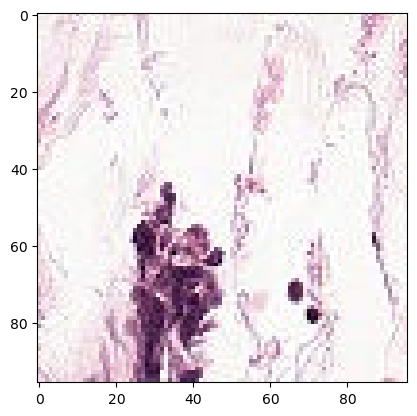

In [4]:
image_path = train_dir + train["id"][1]
img = plt.imread(image_path)
plt.imshow(img)
plt.show()

Finally, let's check the distribution of the label in the training data.

In [5]:
train['label'].value_counts()

0    130908
1     89117
Name: label, dtype: int64

### 3/ Model Architecture

Let's now create our first model. We will make a basic CNN.

In [6]:
# use Sequential to start empty CNN
model = models.Sequential()

# add convolutional layers
model.add(layers.Conv2D(filters=16, kernel_size=(3, 3), activation='relu'))
model.add(layers.Conv2D(filters=16, kernel_size=(3, 3), activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2, 2)))
model.add(layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu'))
model.add(layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2, 2)))

# add dense layers
model.add(layers.Flatten())
model.add(layers.Dense(units=256, activation='relu'))

# add dropout layer to reduce overfitting
model.add(layers.Dropout(0.25))

# use sigmoid since output is binary
model.add(layers.Dense(units=1, activation='sigmoid'))

Now that the model is done, we need to select an optimizer and cuild it.

In [7]:
# use Adam as optimzer (recommended in the course)
opt = optimizers.Adam(learning_rate=0.001)

# compile
model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy', tf.keras.metrics.AUC()])

# build
model.build(input_shape=(256, 64, 64, 3))

Let's display a summary.

In [8]:
# print the model summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (256, 62, 62, 16)         448       
                                                                 
 conv2d_1 (Conv2D)           (256, 60, 60, 16)         2320      
                                                                 
 max_pooling2d (MaxPooling2D  (256, 30, 30, 16)        0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (256, 28, 28, 32)         4640      
                                                                 
 conv2d_3 (Conv2D)           (256, 26, 26, 32)         9248      
                                                                 
 max_pooling2d_1 (MaxPooling  (256, 13, 13, 32)        0         
 2D)                                                    

Before we can train the model, we need to create two image generator to handle the great quantity of images.
* one for the train set, using 80% of the train data
* one for the validate set, using 20% of the train data

In [9]:
# some common variables
img_size_ = 64
batch_size_ = 32
seed_ = 42
epochs_ = 10

# the image generator for the train set
train_generator = ImageDataGenerator(rescale=1/255, validation_split=.2).flow_from_dataframe(
    dataframe=train,
    directory=train_dir,
    x_col="id",
    y_col="label",
    subset="training",
    batch_size=batch_size_,
    seed=seed_,
    class_mode="binary",
    target_size=(img_size_, img_size_))

# the image generator for the validate set
valid_generator = ImageDataGenerator(rescale=1/255, validation_split=.2).flow_from_dataframe(
    dataframe=train,
    directory=train_dir,
    x_col="id",
    y_col="label",
    subset="validation",
    batch_size=batch_size_,
    seed=seed_,
    class_mode="binary",
    target_size=(img_size_, img_size_)) 

Found 176020 validated image filenames belonging to 2 classes.
Found 44005 validated image filenames belonging to 2 classes.


Using both image generators, we can now train the model.

NB: I couldn't manage to leverage my GPU, so this task took around one hour for me!

In [10]:
# train the model
history = model.fit(train_generator, validation_data=valid_generator, epochs=epochs_)

Epoch 1/10
5501/5501 [==============================] - 413s 75ms/step - loss: 0.4346 - accuracy: 0.8019 - auc: 0.8742 - val_loss: 0.4186 - val_accuracy: 0.8097 - val_auc: 0.9156
Epoch 2/10
5501/5501 [==============================] - 442s 80ms/step - loss: 0.3507 - accuracy: 0.8478 - auc: 0.9202 - val_loss: 0.3334 - val_accuracy: 0.8630 - val_auc: 0.9277
Epoch 3/10
5501/5501 [==============================] - 432s 79ms/step - loss: 0.3203 - accuracy: 0.8642 - auc: 0.9339 - val_loss: 0.3235 - val_accuracy: 0.8623 - val_auc: 0.9323
Epoch 4/10
5501/5501 [==============================] - 458s 83ms/step - loss: 0.3002 - accuracy: 0.8732 - auc: 0.9419 - val_loss: 0.3043 - val_accuracy: 0.8709 - val_auc: 0.9439
Epoch 5/10
5501/5501 [==============================] - 457s 83ms/step - loss: 0.2818 - accuracy: 0.8823 - auc: 0.9490 - val_loss: 0.2907 - val_accuracy: 0.8786 - val_auc: 0.9466
Epoch 6/10
5501/5501 [==============================] - 436s 79ms/step - loss: 0.2630 - accuracy: 0.8913 

With our model trained, we can move onto the analysis.

### 4/ Results and Analysis

First, let's plot the accuracy over time (epochs) for the train set and the validate set.

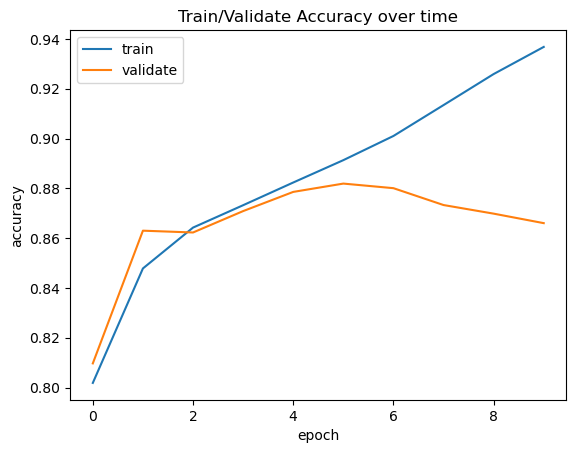

In [21]:
# plot accuracy (train/val) history
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Train/Validate Accuracy over time')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validate'], loc='upper left')
plt.show();

We can see that our model shows clear signs of overfitting:
* the accuracy of the validate set falls after epoch 5
* the discrepancy between train and validate also grows after epoch 5

It seems either Dropout was not a successfull method to prevent overfitting, or a stronger value for Dropout should be used.

The sweet spot is a epoch 5, where the accuracy for the train set and validate set are very close and hover around 88%. This in itself is a good score for a model that is not very deep.

In conlusion, the CNN is a valid model for the problem posed, and further enhancements could include:
* deeper model
* skip step
* higher value of Dropout or a different type of regularization

#### 4.5/ Generating the Kaggle submission

We need to generate the submission for the Kaggle competition.

First, let's retrieve the list of files from the _test_ folder and create an empty dataframe.

In [12]:
# retrieve list of file
file_list = os.listdir(test_dir)

# generate empty dataframe
test_df = pd.DataFrame({'id':file_list})

Before we can run the predict function, we need to create a image generator to handle the quantity of test images (>50k).

In [13]:
# image generator for the test set
test_generator = ImageDataGenerator(rescale=1./255.).flow_from_dataframe(
    dataframe=test_df,
    directory=test_dir,
    x_col='id', 
    y_col=None,
    target_size=(img_size_, img_size_),
    batch_size=1,
    shuffle=False,
    class_mode=None)

Found 57458 validated image filenames.


Now, we can run retrive the predictions using our model.

In [17]:
# predict output using the test images on our model
predictions = model.predict(test_generator, verbose=1)

57458/57458 [==============================] - 431s 7ms/step


Finally, we can write the ouput into out test_df, and write it into a csv file.

In [18]:
# let's rearrange the predictions
predictions = np.transpose(predictions)[0]

# remove the file extension in the id column
test_df['id'] = test_df['id'].apply(lambda x: x.split('.')[0])

# fill the prediction in the label column
test_df['label'] = list(map(lambda x: 0 if x < 0.5 else 1, predictions))

# write the csv file
test_df.to_csv('submission.csv', index=False)

Let's check the distribution of our results.

In [20]:
# display results distribution
test_df['label'].value_counts()

0    35954
1    21504
Name: label, dtype: int64

### 5/ Conclusion

As we have seen above, a Convolutional Neural Network is a good fit for the given problem. Our rather shallow model with a single Dropout managed to reach 88% accuracy on both train and validate sets in only 5 epochs.

However, our model shows clear signs of overfitting, and would require further enhancements to:
* provide better overall accuracy
* reduce overfitting